In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import midi_manipulation


%matplotlib inline

In [3]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    print(files)
    songs = []
    for f in tqdm(files):
        print(f)
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
                print('gottcha')
            else:
                print(np.array(song).shape[0], 'no good')
        except Exception as e:
            raise e    
    return songs

In [4]:
songs = get_songs('./prksn2/') #These songs have already been converted from midi to msgpack
print("{} songs processed".format(len(songs)))

['./prksn2\\prksn2_1.mid', './prksn2\\prksn2_2.mid', './prksn2\\prksn2_3.mid', './prksn2\\prksn2_4-copy.mid', './prksn2\\prksn2_4.mid']


  0%|          | 0/5 [00:00<?, ?it/s]

./prksn2\prksn2_1.mid
gottcha


 20%|██        | 1/5 [00:00<00:02,  1.72it/s]

./prksn2\prksn2_2.mid
gottcha


 40%|████      | 2/5 [00:01<00:02,  1.45it/s]

./prksn2\prksn2_3.mid
gottcha


 60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

./prksn2\prksn2_4-copy.mid
gottcha


 80%|████████  | 4/5 [00:04<00:01,  1.16s/it]

./prksn2\prksn2_4.mid
1 no good


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


4 songs processed


In [5]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 16 #64 #32 #16 #This is the number of timesteps that we will create at a time  (16 = one bar)
n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
n_hidden       = 500 #50 #This is the size of the hidden layer

In [6]:
#x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
#W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
#bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
#bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer

In [7]:
z_dim = n_hidden #100
X_dim = n_visible #mnist.train.images.shape[1]
h_dim = n_hidden #128


In [8]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [9]:
X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
z = tf.placeholder(tf.float32, shape=[None, z_dim], name="z")

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]), name="Q_W1")
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name="Q_b1")

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]), name="Q_W2_mu")
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]), name="Q_b2_mu")

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]),name="Q_W2_sigma")
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]),name="Q_b2_sigma")

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
def Q(X):
    h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

In [11]:
# =============================== P(X|z) ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]), name="P_W1")
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]), name="P_b1")

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]), name="P_W2")
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]), name="P_b2")


def P(z):
    h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

In [12]:
z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss) #check learning rate

#saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

Iter: 0
Loss: 15.77


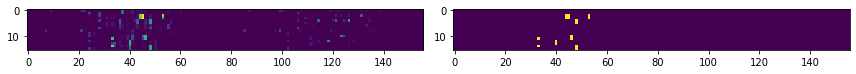

Iter: 100
Loss: 22.68
Iter: 200
Loss: 15.57
Iter: 300
Loss: 18.41
Iter: 400
Loss: 15.66
Iter: 500
Loss: 18.01
Iter: 600
Loss: 15.72
Iter: 700
Loss: 16.35
Iter: 800
Loss: 17.98
Iter: 900
Loss: 15.15
Iter: 1000
Loss: 18.21


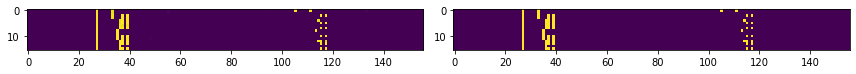

Iter: 1100
Loss: 15.2
Iter: 1200
Loss: 20.71
Iter: 1300
Loss: 15.89
Iter: 1400
Loss: 16.94
Iter: 1500
Loss: 16.3
Iter: 1600
Loss: 15.77
Iter: 1700
Loss: 15.69
Iter: 1800
Loss: 18.62
Iter: 1900
Loss: 22.95
Iter: 2000
Loss: 16.54


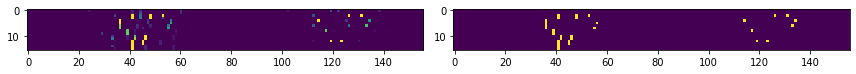

Iter: 2100
Loss: 15.2
Iter: 2200
Loss: 15.49
Iter: 2300
Loss: 15.34
Iter: 2400
Loss: 15.28
Iter: 2500
Loss: 15.2
Iter: 2600
Loss: 16.78
Iter: 2700
Loss: 16.31
Iter: 2800
Loss: 15.34
Iter: 2900
Loss: 15.85
Iter: 3000
Loss: 25.28


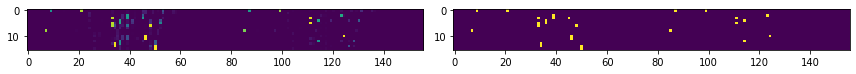

Iter: 3100
Loss: 15.97
Iter: 3200
Loss: 14.97
Iter: 3300
Loss: 19.65
Iter: 3400
Loss: 15.47
Iter: 3500
Loss: 15.51
Iter: 3600
Loss: 15.59
Iter: 3700
Loss: 15.14
Iter: 3800
Loss: 31.91
Iter: 3900
Loss: 22.86
Iter: 4000
Loss: 15.9


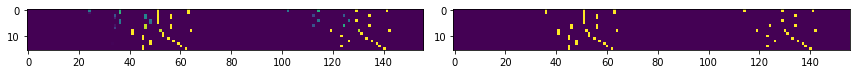

Iter: 4100
Loss: 14.45
Iter: 4200
Loss: 14.8
Iter: 4300
Loss: 16.23
Iter: 4400
Loss: 15.36
Iter: 4500
Loss: 33.03
Iter: 4600
Loss: 16.16
Iter: 4700
Loss: 16.15
Iter: 4800
Loss: 17.9
Iter: 4900
Loss: 17.94
Iter: 5000
Loss: 16.63


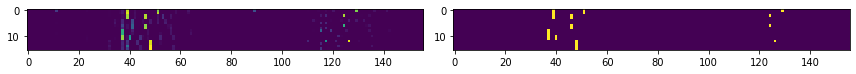

Iter: 5100
Loss: 20.08
Iter: 5200
Loss: 17.41
Iter: 5300
Loss: 16.27
Iter: 5400
Loss: 16.68
Iter: 5500
Loss: 14.71
Iter: 5600
Loss: 16.32
Iter: 5700
Loss: 15.52
Iter: 5800
Loss: 14.4
Iter: 5900
Loss: 15.5
Iter: 6000
Loss: 14.4


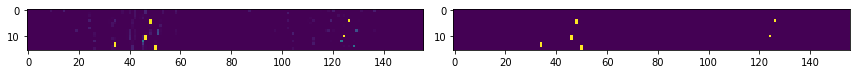

Iter: 6100
Loss: 15.48
Iter: 6200
Loss: 15.02
Iter: 6300
Loss: 16.63
Iter: 6400
Loss: 16.76
Iter: 6500
Loss: 17.03
Iter: 6600
Loss: 15.15
Iter: 6700
Loss: 25.58
Iter: 6800
Loss: 22.05
Iter: 6900
Loss: 20.1
Iter: 7000
Loss: 16.98


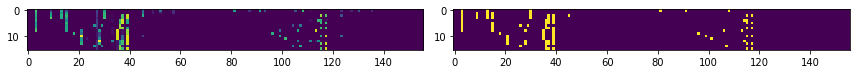

Iter: 7100
Loss: 16.06
Iter: 7200
Loss: 18.52
Iter: 7300
Loss: 16.37
Iter: 7400
Loss: 16.37
Iter: 7500
Loss: 16.39
Iter: 7600
Loss: 14.58
Iter: 7700
Loss: 18.8
Iter: 7800
Loss: 22.77
Iter: 7900
Loss: 22.2
Iter: 8000
Loss: 15.14


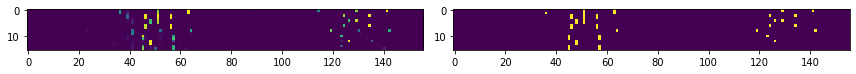

Iter: 8100
Loss: 16.33
Iter: 8200
Loss: 29.86
Iter: 8300
Loss: 18.38
Iter: 8400
Loss: 17.55
Iter: 8500
Loss: 15.19
Iter: 8600
Loss: 16.77
Iter: 8700
Loss: 23.1
Iter: 8800
Loss: 16.79
Iter: 8900
Loss: 16.27
Iter: 9000
Loss: 21.74


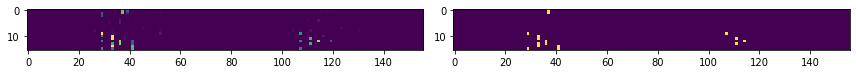

Iter: 9100
Loss: 16.19
Iter: 9200
Loss: 19.42
Iter: 9300
Loss: 31.66
Iter: 9400
Loss: 16.6
Iter: 9500
Loss: 15.6
Iter: 9600
Loss: 14.62
Iter: 9700
Loss: 16.5
Iter: 9800
Loss: 25.64
Iter: 9900
Loss: 20.47
Iter: 10000
Loss: 16.03


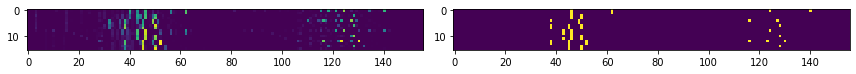

In [17]:
num_epochs = 50000 #The number of training epochs that we are going to run. For each epoch we go through the entire data set.
batch_size = 100 #The number of training examples that we are going to send through the model at a time. 
#lr         = tf.constant(0.005, tf.float32) #The learning rate of our model

i = 0

songs = [songs[0]]
while i <= num_epochs:
    for song in songs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
        # Train the VAE on batch_size examples at a time
        for ind in range(0, len(song), batch_size): 
            X_mb = song[ind:ind+batch_size]
            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
    
    if i % 100 == 0:
        print('Iter: {}'.format(i))
        print('Loss: {:.4}'. format(loss))
    if i % 1000 == 0:
        samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})
        S = np.reshape(samples, (num_timesteps, 2*note_range))
        thresh_S = S>=0.5
        plt.figure(figsize=(12,2))
        plt.subplot(1,2,1)
        plt.imshow(S)
        plt.subplot(1,2,2)
        plt.imshow(thresh_S)
        plt.tight_layout()
        plt.pause(0.1)
        #midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
#                 print(i)
    i += 1

In [18]:
saver = tf.train.Saver()

#Save just in case
mname = 'model'+'_h'+str(n_hidden)+'nt'+str(num_timesteps)
save_path = saver.save(sess, "./tmp/"+mname+".ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ./tmp/model_h500nt16.ckpt


## Training Ended
# Generative Part Starts Here

In [19]:
#tf.reset_default_graph()
#imported_graph = tf.train.import_meta_graph("./tmp/"+mname+".ckpt.meta")

#saver = tf.train.Saver()
#restore_path = saver.restore(sess, "./tmp/"+mname+".ckpt")

#sess = tf.Session()
#imported_graph.restore(sess, tf.train.latest_checkpoint("./tmp/")
#imported_graph.restore(sess, "./tmp/"+mname+".ckpt")

In [22]:
bars = int(25*16/num_timesteps)
print(bars, z_dim)
samples = sess.run(X_samples, feed_dict={z: np.random.randn(bars,z_dim)})
S = np.reshape(samples, (bars*num_timesteps, 2*note_range))
thresh_S = S>=0.7 #0.5
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_long__nt16")

25 500


(385, 156)


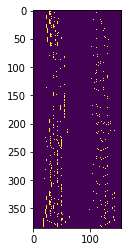

In [55]:
vn = 8 #tuple structure with longer phrases 2, 3, 5, 8 
q = "./vf/vf_no"+str(vn)+".mid"
#q = "./prokofiev_vision_fugitives_22_(c)ungar.mid"
querysong = np.array(midi_manipulation.midiToNoteStateMatrix(q))
print(np.shape(querysong))
plt.imshow(querysong)

In [56]:
song = np.array(querysong)
zeropadsong = np.zeros(((np.floor(song.shape[0]/num_timesteps).astype(int)+1)*num_timesteps, song.shape[1]))
zeropadsong[:song.shape[0],:song.shape[1]] = song
#song = song[:(np.floor(song.shape[0]/num_timesteps).astype(int)+1)*num_timesteps]
song = np.reshape(zeropadsong, [int(song.shape[0]/num_timesteps)+1, song.shape[1]*num_timesteps])
print(np.shape(song))

decode_bars = np.shape(song)[0]
S_reconstruct = np.reshape(song, (decode_bars*num_timesteps, 2*note_range))

midi_manipulation.noteStateMatrixToMidi(S_reconstruct, "out/song_reconstruct"+"_vf"+str(vn))   

(25, 2496)


In [60]:
# Encode the VAE on query
# These are the functions for Encoding-Decoding
# Encoding: Reading from Data to get z_sample
#z_mu, z_logvar = Q(X)
#z_sample = sample_z(z_mu, z_logvar)
# Decoding: Sampling from z
#X_samples, _ = P(z)

Xq = song
zs = False
if zs:
    zq_sample = sess.run(z_sample, feed_dict={X: Xq})
    ztype = "_zs"
else: #using the mean instead of sampling: 
    zq_sample = sess.run(z_mu, feed_dict={X: Xq})  #Check why this causes breaks / missing values in the output
    ztype = "_zmu"
print(np.shape(zq_sample))

(25, 500)


In [61]:
# Decode with the z from query
samples = sess.run(X_samples, feed_dict={z: zq_sample})

S = np.reshape(samples, (decode_bars*num_timesteps, 2*note_range))
thresh_S = S>=0.66 #0.857 #0.5
fout = "generated_query"+'_h'+str(n_hidden)+'_nt'+str(num_timesteps)+str(ztype)+"_vf"+str(vn)
print(fout)
midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/"+fout)    

generated_query_h500_nt16_zmu_vf8


(25, 500)


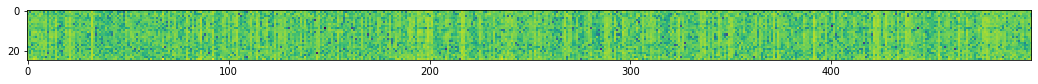

In [62]:
plt.figure(figsize=(18,5))
plt.imshow(np.log(np.abs(zq_sample)))
print(np.shape(zq_sample))